# Understanding Graphical Models

This notebook offers a brief overview of probabilistic graphical models (PGMs). These models visually represent the factorization of a probability distribution, allowing for conditional independencies to be read off the graph. PGMs have been successfully applied for many machine learning tasks.

We also introduce causal graphical models. These models attach causal semantics to PGMs, which allows us to talk about causality.

In [2]:
import numpy as np
import pandas as pd
from fcit import fcit
np.random.seed(123123)

In [3]:
%load_ext tikzmagic

## Probabilistic Graphical Models

To begin, we consider a class of PGMs called directed acyclic graphs. These contain only directed edges ($ \to$) and do not have any cycles. A DAG will have three basic triplet structures: a chain, a fork, and a collider (shown below).

In [4]:
%%tikz -sc 1.4
\begin{scope}
\path[->, very thick]
node[] (x) at (0,0) {$X$}
node[] (z) at (2, 0) {$Z$}
node[] (y) at (4, 0) {$Y$}

(x) edge[blue] (z)
(z) edge[blue] (y)
;
\end{scope}


In [5]:
# Testing marginal and conditional independencies in a chain:
N = 1000
X = np.random.normal(size=N)
Z = np.random.normal(loc=X, scale=1, size=N)
Y = np.random.normal(loc=Z, scale=1, size=N)

pval_i = fcit.test(X.reshape(-1, 1), Y.reshape(-1, 1))
print("p-val for null hypothesis of  X _|_ Y: ", pval_i)
pval_ci = fcit.test(X.reshape(-1, 1), Y.reshape(-1, 1), Z.reshape(-1, 1))
print("p-val for null hypothesis of X _|_ Y | Z: ", pval_ci)

p-val for null hypothesis of  X _|_ Y:  0.0001656396643407924
p-val for null hypothesis of X _|_ Y | Z:  0.8246916685898676


We can see that at a statistical significance level of $\alpha = 0.05$, we would reject the null hypothesis that $X \bot Y$ but accept the null hypothesis that $X \bot Y | Z $. In the graph, we only obtain conditional independence between $X$ and $Y$ if we condition on $Z$ to block the flow of association.

In [6]:
%%tikz -sc 1.4
\begin{scope}
\path[->, very thick]
node[] (x) at (0,0) {$X$}
node[] (z) at (2, 0) {$Z$}
node[] (y) at (4, 0) {$Y$}

(z) edge[blue] (x)
(z) edge[blue] (y)
;
\end{scope}

In [7]:
# Testing marginal and conditional independencies in a fork:
Z = np.random.normal(size=N)
X = np.random.normal(loc=Z, scale=1, size=N)
Y = np.random.normal(loc=Z, scale=1, size=N)

pval_i = fcit.test(X.reshape(-1, 1), Y.reshape(-1, 1))
print("p-val for X _|_ Y: ", pval_i)
pval_ci = fcit.test(X.reshape(-1, 1), Y.reshape(-1, 1), Z.reshape(-1, 1))
print("p-val for X _|_ Y | Z: ", pval_ci)

p-val for X _|_ Y:  0.00013525990503174338
p-val for X _|_ Y | Z:  0.8642729830547147


A similar story holds here where we do not conclude $X \bot Y$, but we do conclude that $X \bot Y | Z$ at $\alpha = 0.05$.

In [9]:
%%tikz -sc 1.4
\begin{scope}
\path[->, very thick]
node[] (x) at (0,0) {$X$}
node[] (z) at (2, 0) {$Z$}
node[] (y) at (4, 0) {$Y$}

(x) edge[blue] (z)
(y) edge[blue] (z)
;
\end{scope}

In [10]:
# Testing marginal and conditional independencies in a collider:
X = np.random.normal(size=N)
Y = np.random.normal(loc=0, scale=1, size=N)
Z = np.random.normal(loc=X + Y, scale=1, size=N)

pval_i = fcit.test(X.reshape(-1, 1), Y.reshape(-1, 1))
print("p-val for X _|_ Y: ", pval_i)
pval_ci = fcit.test(X.reshape(-1, 1), Y.reshape(-1, 1), Z.reshape(-1, 1))
print("p-val for X _|_ Y | Z: ", pval_ci)

p-val for X _|_ Y:  0.6324183722605379
p-val for X _|_ Y | Z:  0.011609659492997295


In contrast, for the collider, we do not reject the hypothesis that $X \bot Y$, but we do reject the hypothesis that $X \bot Y | Z$ at $\alpha = 0.05$.

Furthermore, for the special case of colliders, there is an additional rule: if we condition on any descendant of $Z$ (any variable where a series of directed edges from Z to that variable exists), then the conditional independence is also rejected, as shown below.

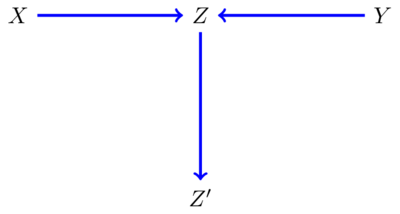

In [14]:
%%tikz -sc 1.4
\begin{scope}
\path[->, very thick]
node[] (x) at (0,0) {$X$}
node[] (z) at (2, 0) {$Z$}
node[] (y) at (4, 0) {$Y$}
node[] (zp) at (2, -2) {$Z'$}

(x) edge[blue] (z)
(y) edge[blue] (z)
(z) edge[blue] (zp)
;
\end{scope}

In [18]:
X = np.random.normal(size=N)
Y = np.random.normal(loc=0, scale=1, size=N)
Z = np.random.normal(loc=X + Y, scale=1, size=N)
Zp = np.random.normal(loc=Z, scale=1, size=N)
pval_i = fcit.test(X.reshape(-1, 1), Y.reshape(-1, 1))
print("p-val for X _|_ Y: ", pval_i)
pval_ci = fcit.test(X.reshape(-1, 1), Y.reshape(-1, 1), Zp.reshape(-1, 1))
print("p-val for X _|_ Y | Z': ", pval_ci)

p-val for X _|_ Y:  0.9778722068490746
p-val for X _|_ Y | Z':  0.07340466123288071


## Causal Graphical Models
Thus far we have discussed probabilistic graphical models. These models allow us to compute associations, or to ask questions of the form "given Z, are X and Y associated?". Associations are very useful when we need to perform prediction tasks, such as much of those that appear in machine learning problems (such as classification or regression).

However, without further structure, we cannot ask questions such as "If I intervene on X, what happens to Y?". These questions arise in scientific work, where we seek to establish not only association but causation.

We resolve this by introducing causal graphical models. These are probabilistic models that also incorporate a non-parametric structural equation model (NPSEM) amongst the variables.

To aid discussion, let us say that we have the following NPSEM with independent errors:

\begin{align*}
X &= f_X (\epsilon_X)\\
Z &= f_Z (X, \epsilon_Z) \\
Y &= f_Y (Z, \epsilon_Y)
\end{align*}

where $\epsilon_X, \epsilon_Z, \epsilon_Y$ are all independent error terms that are random variables and thus have some distribution. The functions $f_X, f_Z, f_Y$ are all deterministic functions that take their inputs and return an output.

Given this structural causal model we might then consider questions like "if I were to set $Z=1$, what is the distribution of $Y$?". This question is a hypothetical counterfactual about a potential intervention. Thus, we would denote it as $p(Y(z=1))$. Contrast this with the question " given that I see $Z =1$, what is the distribution of $Y$?", which we would denote $p(Y | Z=1)$.